# **EDA датасета по сердечно-сосудистым заболеваниям**

## **Введение**

EDA датасета по сердечно-сосудистым заболеваниям проводится с целью оценки структуры, целостности и полноты данных, а также обнаружения выбросов и аномалий.

## **Подготовка к работе**
Импортируем необходимые для обработки данных библиотеки и загружаем данные

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_id = "19T-Gm5Dovnae7htHjJP2gUt3Tyl6NPp2"  # ID файла на Google Drive
file_url = f"https://drive.google.com/uc?id={file_id}"

try:
    df = pd.read_csv(file_url, delimiter=';')
    print("Данные загружены")
except Exception as e:
    print("Произошла ошибка при загрузке файла:", e)
    raise   

print(f"Размер датасета: {df.shape}")
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")
print("\n")

print("Выведем первые 5 строк датасета")
print(df.head())
print("\n")

print("Узнаем информацию о типах данных")
print(df.info())
print("\n")

Данные загружены
Размер датасета: (1000, 16)
Количество строк: 1000
Количество столбцов: 16


Выведем первые 5 строк датасета
   Age  Gender  Cholesterol  Blood Pressure  Heart Rate  Smoking  \
0   75  Female          228             119          66  Current   
1   48    Male          204             165          62  Current   
2   53    Male          234              91          67    Never   
3   69  Female          192              90          72  Current   
4   62  Female          172             163          93    Never   

  Alcohol Intake  Exercise Hours Family History Diabetes Obesity  \
0          Heavy               1             No       No     Yes   
1            NaN               5             No       No      No   
2          Heavy               3            Yes       No     Yes   
3            NaN               4             No      Yes      No   
4            NaN               6             No      Yes      No   

   Stress Level  Blood Sugar Exercise Induced Angina   C

## **Оценка полноты данных (completeness)**

Полнота данных по колонкам
                Колонка  Заполнено (%)  Пропусков  Заполнено строк
         Alcohol Intake           66.0        340              660
                    Age          100.0          0             1000
            Cholesterol          100.0          0             1000
                 Gender          100.0          0             1000
         Blood Pressure          100.0          0             1000
             Heart Rate          100.0          0             1000
                Smoking          100.0          0             1000
         Exercise Hours          100.0          0             1000
         Family History          100.0          0             1000
               Diabetes          100.0          0             1000
                Obesity          100.0          0             1000
           Stress Level          100.0          0             1000
            Blood Sugar          100.0          0             1000
Exercise Induced Angina          10

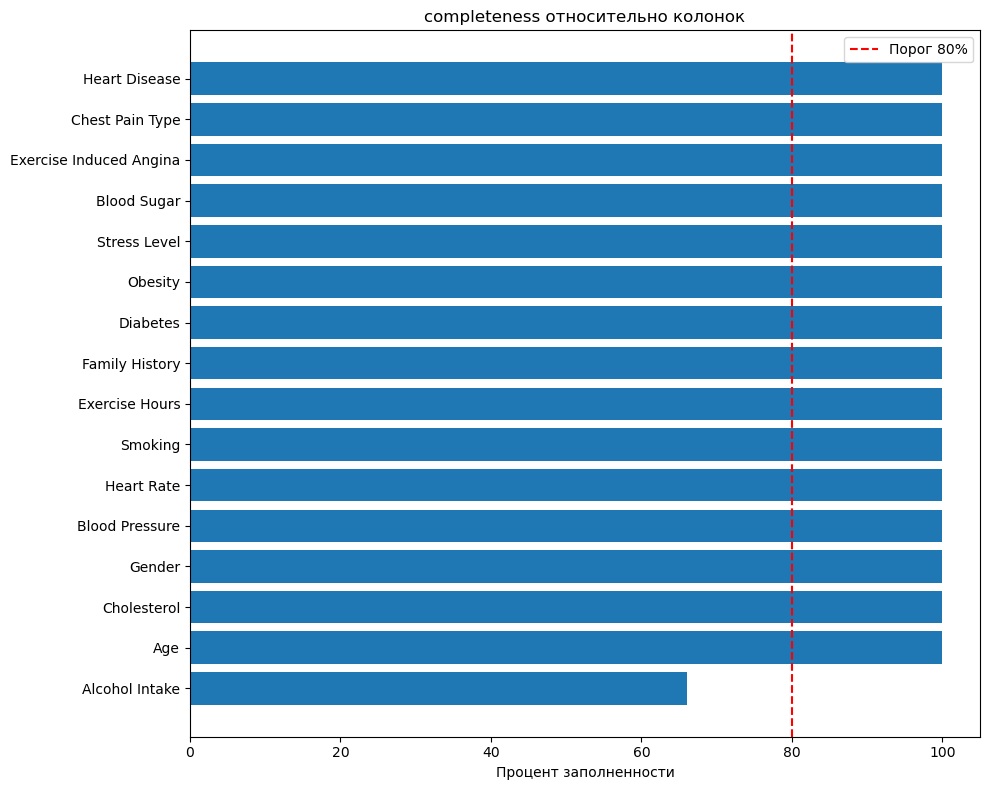

Рекомендации
Хорошее качество данных. Несколько колонок требуют внимания.


In [43]:
print('Полнота данных по колонкам')
# Создаем таблицу с результатами
results = []
for column in df.columns:
    total_rows = len(df)
    missing_count = df[column].isna().sum()
    filled_count = total_rows - missing_count
    completeness = (filled_count / total_rows) * 100
    
    results.append({
        'Колонка': column,
        'Заполнено (%)': round(completeness, 1),
        'Пропусков': missing_count,
        'Заполнено строк': filled_count
    })

# Создаем DataFrame и сортируем по полноте
completeness_df = pd.DataFrame(results)
completeness_df = completeness_df.sort_values('Заполнено (%)')

# Показываем результаты
print(completeness_df.to_string(index=False))
print()

# Статистика по качеству данных
perfect_columns = len(completeness_df[completeness_df['Заполнено (%)'] == 100])
good_columns = len(completeness_df[completeness_df['Заполнено (%)'] >= 90])
bad_columns = len(completeness_df[completeness_df['Заполнено (%)'] < 80])
empty_columns = len(completeness_df[completeness_df['Заполнено (%)'] == 0])

print(f"Колонок полностью заполнено (100%): {perfect_columns}")
print(f"Колонок хорошо заполнено (>=90%): {good_columns}")
print(f"Колонок плохо заполнено (<80%): {bad_columns}")
print(f"Колонок полностью пустых (0%): {empty_columns}")

# При необходимости показываем проблемные колонки
problem_columns = completeness_df[completeness_df['Заполнено (%)'] < 80]
if len(problem_columns) > 0:
    print(f"\n Проблемные колонки (заполнено меньше 80%):")
    for _, row in problem_columns.iterrows():
        print(f"   - {row['Колонка']}: {row['Заполнено (%)']}%")

# Визуализация
print("График")
plt.figure(figsize=(10, 8))

# График полноты по колонкам
plt.barh(completeness_df['Колонка'], completeness_df['Заполнено (%)'])
plt.xlabel('Процент заполненности')
plt.title('completeness относительно колонок')
plt.axvline(x=80, color='red', linestyle='--', label='Порог 80%')
plt.legend()

plt.tight_layout()
plt.show()

# Рекомендации
print("Рекомендации")
if bad_columns == 0:
    print("Отличное качество данных! Все колонки заполнены хорошо.")
elif bad_columns < 5:
    print("Хорошее качество данных. Несколько колонок требуют внимания.")
else:
    print("Есть проблемы с качеством данных. Много колонок с пропусками.")

Таким образом, в представленном датасете хорошее качество данных, отличающихся высокой полнотой, за исключением колонки Alcohol Intake

## **Оценка уникальности данных**

In [49]:
# Проверка уникальности строк
duplicate_count = df.duplicated().sum()
uniqueness_score = 1 - (duplicate_count / len(df))

print("Оценка уникальности строк")
print(f"Всего строк в датасете: {len(df)}")
print(f"Найдено дубликатов: {duplicate_count}")
print(f"Оценка уникальности: {uniqueness_score:.3f}")

# Проверка
if uniqueness_score == 1.0:
    print("Все хорошо: Дубликатов нет")
else:
    print("Проблема: Есть дубликаты")

Оценка уникальности строк
Всего строк в датасете: 1000
Найдено дубликатов: 0
Оценка уникальности: 1.000
Все хорошо: Дубликатов нет


Все строки в датасете уникальны

## **Поиск выбросов методом IQR**

Проводим статистический анализ числовых данных с целью выявления выбросов


--- Age ---
Выбросов: 0 (0.00%)
Границы выбросов: [-1.50, 106.50]

--- Cholesterol ---
Выбросов: 0 (0.00%)
Границы выбросов: [51.50, 447.50]

--- Blood Pressure ---
Выбросов: 0 (0.00%)
Границы выбросов: [43.38, 228.38]

--- Heart Rate ---
Выбросов: 0 (0.00%)
Границы выбросов: [41.50, 117.50]

--- Exercise Hours ---
Выбросов: 0 (0.00%)
Границы выбросов: [-5.50, 14.50]

--- Stress Level ---
Выбросов: 0 (0.00%)
Границы выбросов: [-4.50, 15.50]

--- Blood Sugar ---
Выбросов: 0 (0.00%)
Границы выбросов: [9.50, 261.50]

--- Heart Disease ---
Выбросов: 0 (0.00%)
Границы выбросов: [-1.50, 2.50]
Визуализация выбросов


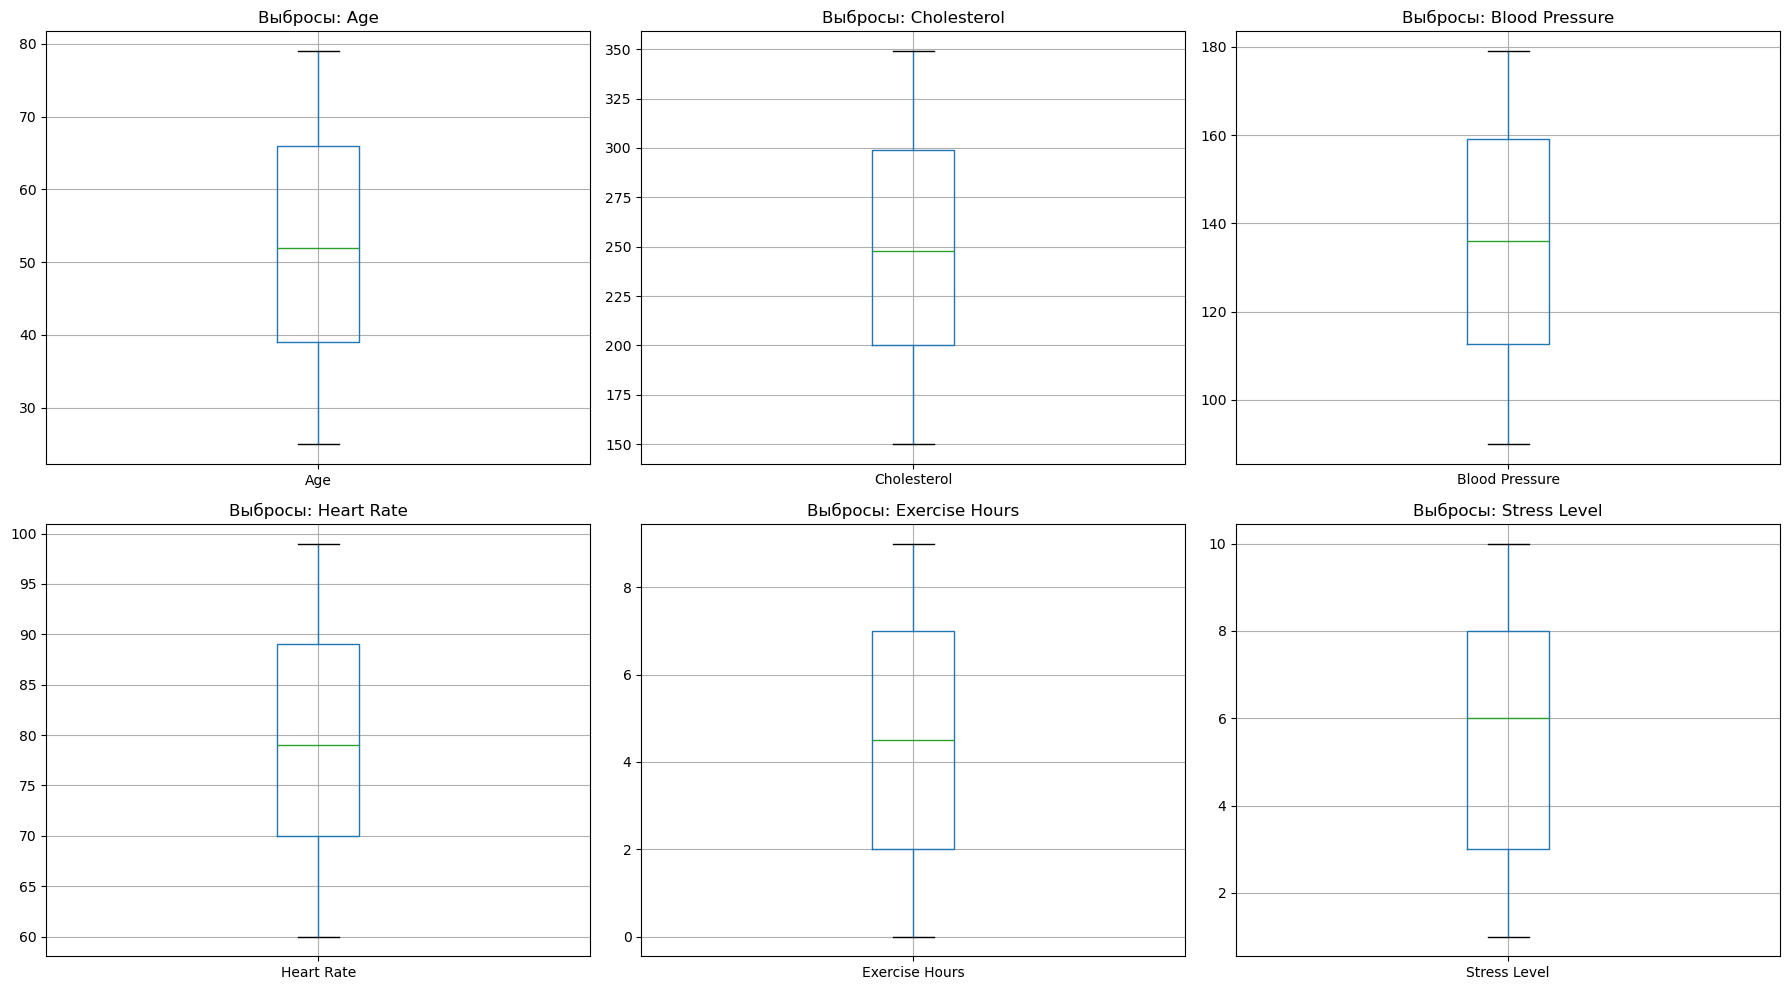

In [54]:
numerical_columns = df.select_dtypes(include=[np.number]).columns

outliers_summary = {}

for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_count = len(outliers)
    outliers_percentage = (outliers_count / len(df)) * 100
    
    outliers_summary[col] = {
        'outliers_count': outliers_count,
        'outliers_percentage': outliers_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    
    print(f"\n--- {col} ---")
    print(f"Выбросов: {outliers_count} ({outliers_percentage:.2f}%)")
    print(f"Границы выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Визуализация выбросов
if len(numerical_columns) > 0:
    print("Визуализация выбросов")
    
    # Ограничим количество графиков для читаемости
    cols_to_plot = numerical_columns[:6]  # Первые 6 числовых колонок
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(cols_to_plot):
        if i < len(axes):
            df.boxplot(column=col, ax=axes[i])
            axes[i].set_title(f'Выбросы: {col}')
    
    plt.tight_layout()
    plt.show()

Теперь проведем анализ только категориальных колонок

Категориальных колонок: 8

Gender:
   Всего уникальных значений: 2
   Пропущенные значения: 0
Возможные значения:
   1. Female: 503 записей
   2. Male: 497 записей


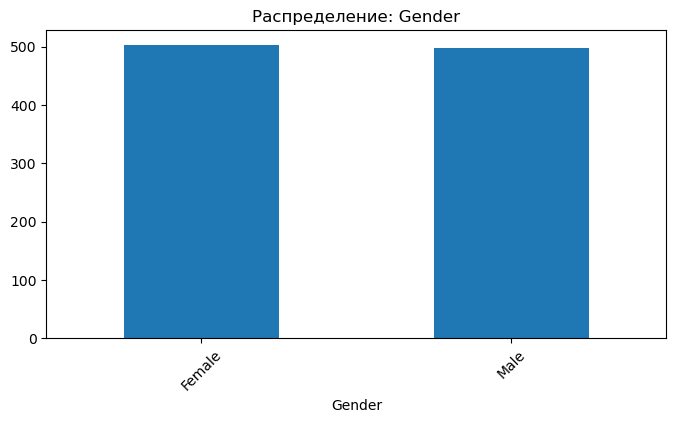


Smoking:
   Всего уникальных значений: 3
   Пропущенные значения: 0
Возможные значения:
   1. Never: 338 записей
   2. Current: 336 записей
   3. Former: 326 записей


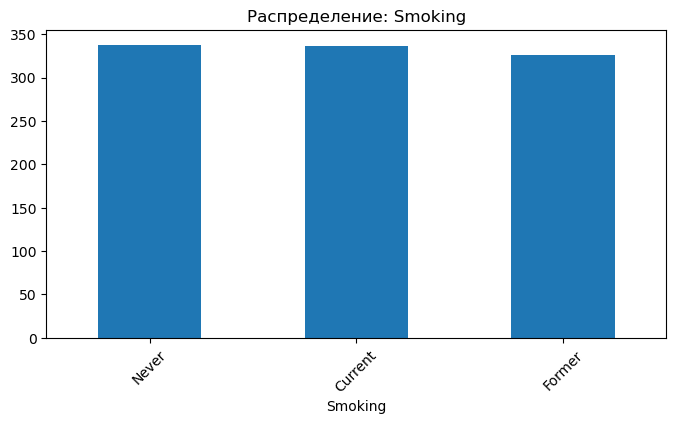


Alcohol Intake:
   Всего уникальных значений: 2
   Пропущенные значения: 340
Возможные значения:
   1. Heavy: 346 записей
   2. Moderate: 314 записей


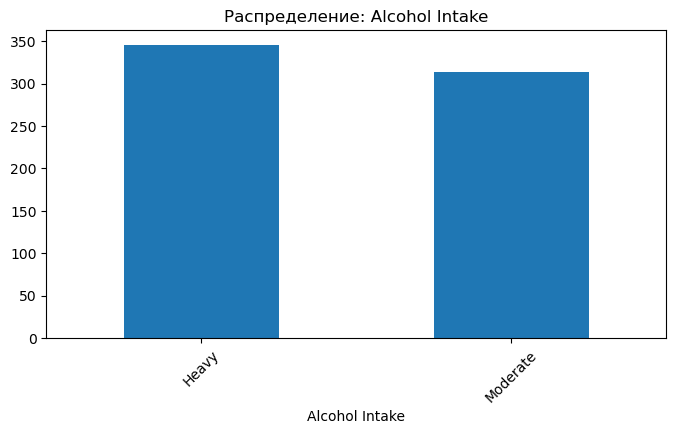


Family History:
   Всего уникальных значений: 2
   Пропущенные значения: 0
Возможные значения:
   1. No: 501 записей
   2. Yes: 499 записей


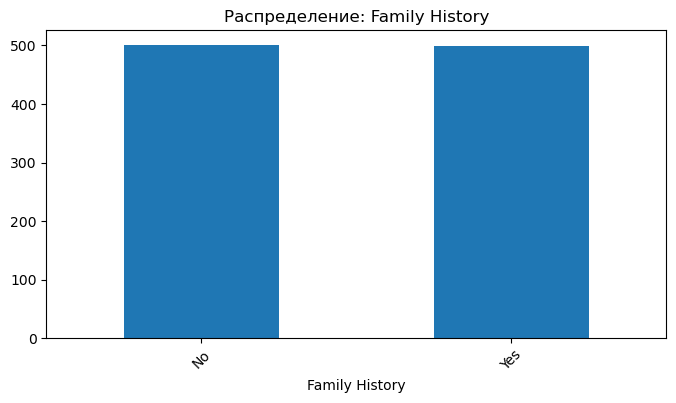


Diabetes:
   Всего уникальных значений: 2
   Пропущенные значения: 0
Возможные значения:
   1. Yes: 505 записей
   2. No: 495 записей


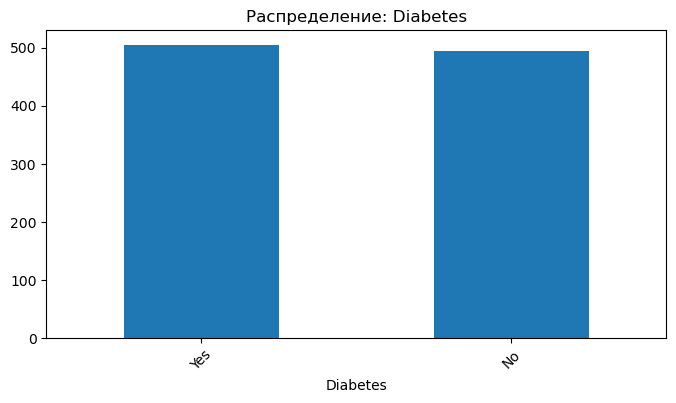


Obesity:
   Всего уникальных значений: 2
   Пропущенные значения: 0
Возможные значения:
   1. No: 501 записей
   2. Yes: 499 записей


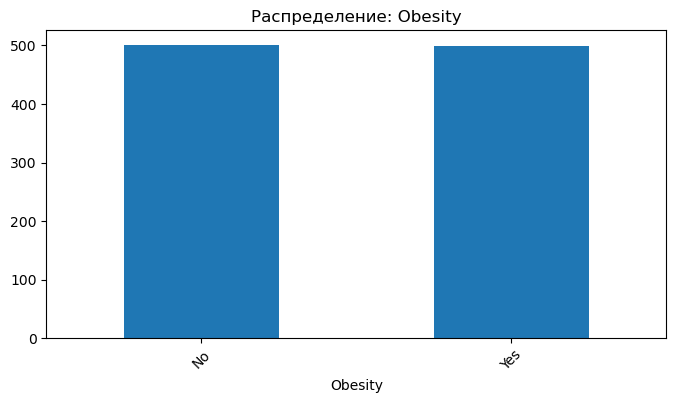


Exercise Induced Angina:
   Всего уникальных значений: 2
   Пропущенные значения: 0
Возможные значения:
   1. No: 528 записей
   2. Yes: 472 записей


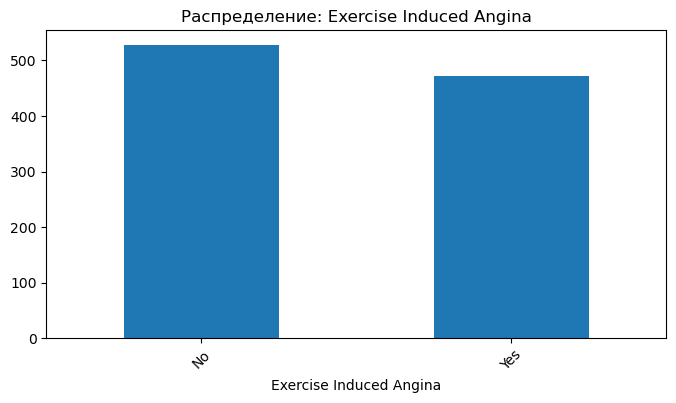


Chest Pain Type:
   Всего уникальных значений: 4
   Пропущенные значения: 0
Возможные значения:
   1. Non-anginal Pain: 256 записей
   2. Typical Angina: 250 записей
   3. Asymptomatic: 248 записей
   4. Atypical Angina: 246 записей


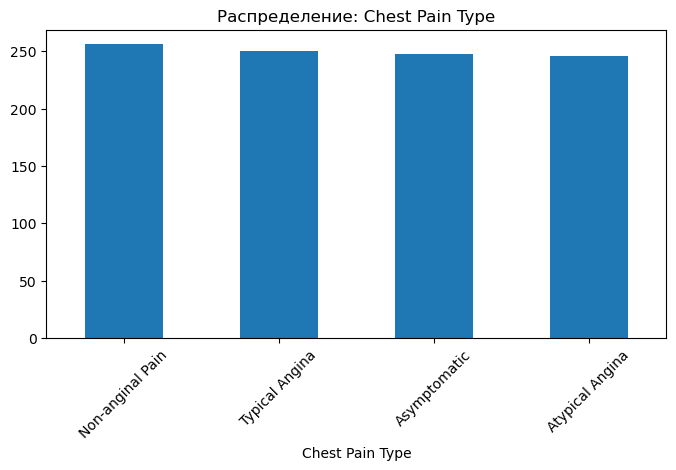


Анализ завершен! Обработано 8 категориальных колонок.


In [55]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(f"Категориальных колонок: {len(categorical_cols)}")

for col in categorical_cols:
    print(f"\n{col}:")
    print(f"   Всего уникальных значений: {df[col].nunique()}")
    print(f"   Пропущенные значения: {df[col].isna().sum()}")
    
    value_counts = df[col].value_counts()
    print("Возможные значения:")
    for i, (value, count) in enumerate(value_counts.head().items(), 1):
        print(f"   {i}. {value}: {count} записей")
    
    # Визуализация для колонок с малым числом уникальных значений
    if df[col].nunique() <= 10:
        plt.figure(figsize=(8, 4))
        value_counts.head(10).plot(kind='bar')
        plt.title(f'Распределение: {col}')
        plt.xticks(rotation=45)
        plt.show()

print(f"\nАнализ завершен! Обработано {len(categorical_cols)} категориальных колонок.")

## **Выводы**

### Структура
Датасет содержит 16 признаков и 1000 строк
Типы данных корректны для всех колонок

### Полнота данных
Все данные в датасете уникальны, а также имеют хорошее качество, т.к. практически все колонки полноценны.
Однако колонка Alcohol Intake заполнена только на 66.0%. Соответсвтенно, для адекватного анализа данных в дальнейшем, чтобы сохранить объем выборки, необходимо удалить данный столбец.

### Выбросы
В числовых данных выбросов не обнаружено
Из категориальных данных проблемы выявлены только в Alcohol Intake